# Step 1: Write Segmentation Algorithm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation
Let's assume that, for the purposes of this, that de-noising the images would be too expensive because
our application has to run on a mobile device.   Thus, you are not allowed to denoise the images before applying the
random walker algorithm.

In [4]:
import numpy as np
from skimage import io, color
from skimage.segmentation import random_walker
from skimage.filters import threshold_otsu
from skimage.morphology import erosion, dilation, square
from skimage.measure import label, regionprops  
from skimage.util import img_as_ubyte  
import matplotlib.pyplot as plt

def segleaf(I):
    """
    Leaf segmentation using random walker with post-processing
    :param I: Input image (color image)
    
    :return: Binary mask representing the segmentation
    """
    green_channel = I[:, :, 0]
    thresh = threshold_otsu(green_channel)
    lower_thresh = 105  

    # Create markers for the random walker algorithm using the green channel
    markers = np.zeros(green_channel.shape, dtype=np.uint)
    markers[green_channel > thresh] = 2  
    markers[green_channel <= lower_thresh] = 1  

    # random walker segmentation
    labels = random_walker(green_channel, markers, beta=60, tol=0.001, mode='bf', copy=True, return_full_prob=False, spacing=None, prob_tol=0.001)

    # Post-processing: Erosion and Dilation
    segmented_mask = (labels == 2) 
    eroded_mask = erosion(segmented_mask, square(2))
    dilated_mask = dilation(eroded_mask, square(9))
    
    h, w = dilated_mask.shape
    for region in regionprops(label(dilated_mask)):
        min_row, min_col, max_row, max_col = region.bbox
        if (
            min_row == 0
            or min_col == 0
            or max_row == h
            or max_col == w
        ):
            dilated_mask[dilated_mask == region.label] = 1
            leaf_mask = np.invert(dilated_mask)

    return leaf_mask




# Step 2: Write a Validation driver program.

Write code that segments each image, and computes the DSC for each segmentation.  Print the DSC of each segmentation.  At the end, print the average of the DSC over all of the images. 


In [5]:
import os
from skimage.metrics import structural_similarity as ssim
from skimage.measure import label
from skimage.color import label2rgb
from skimage.transform import resize

def dice_coefficient(bwA, bwG):
    '''
    Dice coefficient between two binary images
    :param bwA: a binary (dtype='bool') image
    :param bwG: a binary (dtype='bool') image
    :return: the Dice coefficient between them
    '''
    intersection = np.logical_and(bwA, bwG)

    return 2.0*np.sum(intersection) / (np.sum(bwA) + np.sum(bwG))


def compute_dsc(segmented_image, ground_truth):
    common_shape = (min(segmented_image.shape[0], ground_truth.shape[0]),
                    min(segmented_image.shape[1], ground_truth.shape[1]))
    segmented_image = resize(segmented_image, common_shape, anti_aliasing=False)
    ground_truth = resize(ground_truth, common_shape, anti_aliasing=False)

    segmented_image = (segmented_image > 0.5)  
    ground_truth = (ground_truth > 0.5)  

    return dice_coefficient(segmented_image, ground_truth)

def validate_images(image_dir, ground_truth_dir):
    dsc_scores = []
    image_files = os.listdir(image_dir)

    for image_file in image_files:
        if image_file.endswith('.png'):
            image_path = os.path.join(image_dir, image_file)
            image = io.imread(image_path)

            ground_truth_path = os.path.join(ground_truth_dir, image_file)
            ground_truth = io.imread(ground_truth_path)

            segmented_mask = segleaf(image)

            dsc = compute_dsc(segmented_mask, ground_truth)
            print(f"{image_file}: DSC = {dsc:.4f}")
            
            dsc_scores.append(dsc)

    average_dsc = np.mean(dsc_scores)
    print(f"Average DSC: {average_dsc:.4f}")

if __name__ == "__main__":
    image_dir = "C:\\Users\\ducth\\cmpt 487 asm\\asm4\\noisyimages"
    ground_truth_dir = "C:\\Users\\ducth\\cmpt 487 asm\\asm4\\groundtruth"

    validate_images(image_dir, ground_truth_dir)


image_0001.png: DSC = 0.9884
image_0002.png: DSC = 0.9351
image_0005.png: DSC = 0.9832
image_0007.png: DSC = 0.7759
image_0009.png: DSC = 0.9382
image_0010.png: DSC = 0.7240
image_0011.png: DSC = 0.9839
image_0015.png: DSC = 0.9871
image_0018.png: DSC = 0.9554
image_0019.png: DSC = 0.9853
image_0078.png: DSC = 0.7442
image_0080.png: DSC = 0.9825
image_0089.png: DSC = 0.9743
image_0090.png: DSC = 0.8124
image_0099.png: DSC = 0.9748
image_0100.png: DSC = 0.9779
image_0104.png: DSC = 0.9811
image_0105.png: DSC = 0.9224
image_0110.png: DSC = 0.9761
image_0113.png: DSC = 0.9632
image_0132.png: DSC = 0.9612
image_0160.png: DSC = 0.9603
image_0161.png: DSC = 0.9451
image_0162.png: DSC = 0.5463
image_0163.png: DSC = 0.9142
image_0165.png: DSC = 0.8839
image_0166.png: DSC = 0.9721
image_0171.png: DSC = 0.9834
image_0174.png: DSC = 0.9820
image_0175.png: DSC = 0.9817
Average DSC: 0.9232


# Step 3:  Display Examples



Text(0.5, 1.0, 'Bad Result')

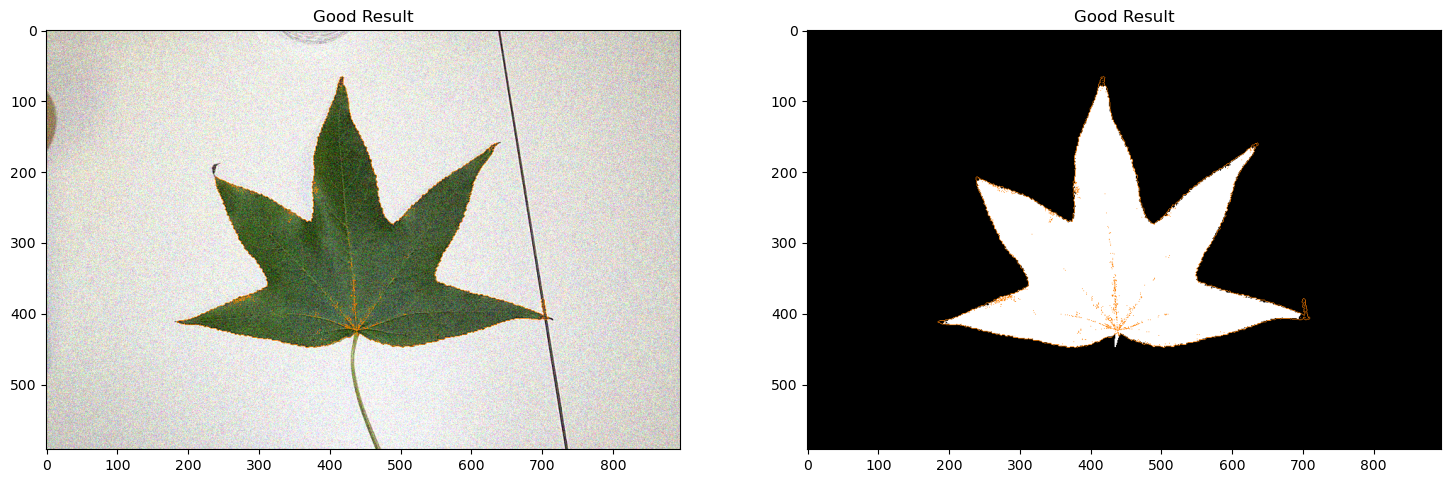

<Figure size 640x480 with 0 Axes>

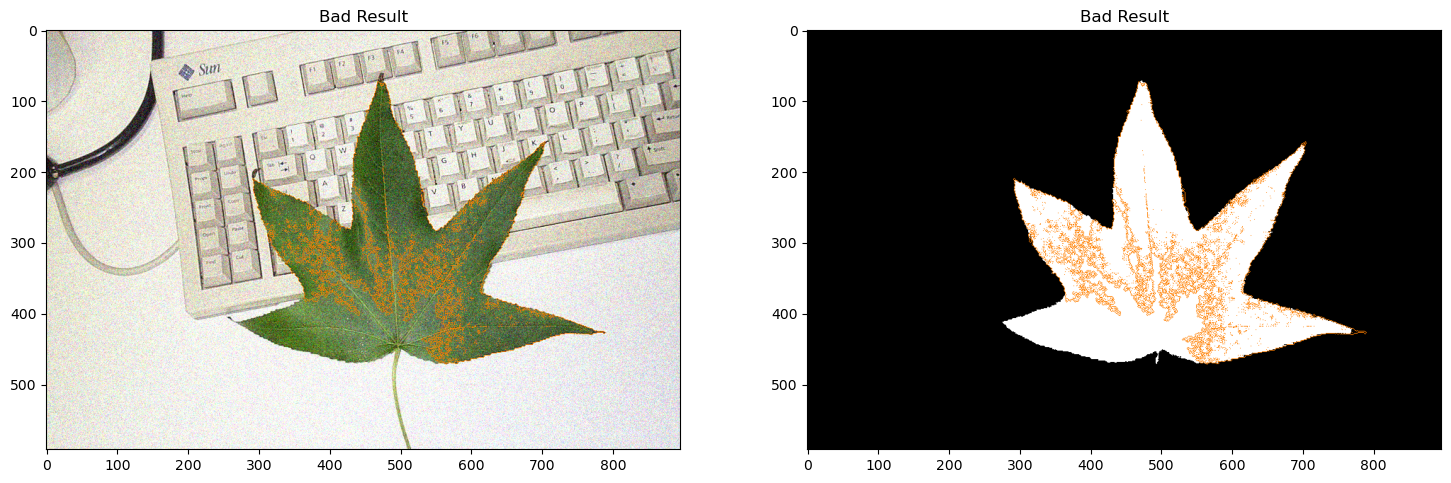

In [25]:
import skimage.morphology as morph
import skimage.segmentation as seg

good =  io.imread("C:\\Users\\ducth\\cmpt 487 asm\\asm4\\noisyimages\\image_0001.png")
bad =  io.imread("C:\\Users\\ducth\\cmpt 487 asm\\asm4\\noisyimages\\image_0007.png")
good_gt = io.imread("C:\\Users\\ducth\\cmpt 487 asm\\asm4\\groundtruth\\image_0001.png")
bad_gt = io.imread("C:\\Users\\ducth\\cmpt 487 asm\\asm4\\groundtruth\\image_0007.png")

good_seg = segleaf(good)
bad_seg = segleaf(bad)

good_label = morph.label(good_seg)
bad_label = morph.label(bad_seg)

plt.subplots(1, 2, figsize=(18,6))
plt.subplot(121)
plt.imshow(seg.mark_boundaries(good, good_label, color=(1,.5,0)))
plt.title('Good Result')
plt.subplot(122)
plt.imshow(seg.mark_boundaries(good_gt, good_label, color=(1,.5,0)))
plt.title('Good Result')

plt.figure()
plt.subplots(1, 2, figsize=(18,6))
plt.subplot(121)
plt.imshow(seg.mark_boundaries(bad, bad_label, color=(1,.5,0)))
plt.title('Bad Result')
plt.subplot(122)
plt.imshow(seg.mark_boundaries(bad_gt, bad_label, color=(1,.5,0)))
plt.title('Bad Result')

# Step 4: Reflection






In [ ]:
"""
The Step 1 segmentation algorithm aims to extract a green leaf from a noisy color 
image. It begins by extracting the green channel (R channel in RGB) and applies a
lower threshold to distinguish between the leaf foreground and background, taking
care not to misclassify black regions as background. Two markers are created, 
designating pixels above the Otsu threshold as the background marker and those 
below the lower threshold as the foreground marker. The random walker algorithm is
then applied for initial segmentation, using a beta value of 120 and a convergence 
tolerance of 0.001 in "bf" mode. Post-processing involves erosion to remove small 
noise and dilation to connect or expand regions. We also take advantage of there 
is only one leaf per image and the leaf alway close to the center, never touch any
edges of the image. Aa result, we can erase the region that touch edge of the picture
and mark it as not the leaf segmentation. The result is a binary mask that 
accurately represents the segmented leaf while addressing black regions in the 
original image. This algorithm combines color thresholding, marker assignment, 
random walker, and morphological operations to robustly segment the leaf from 
noisy images.
"""


"""
The algorithm's ability to segment a green leaf in a noisy image is commendable, 
but several factors could potentially lead to even better results. Variations in 
color and lighting conditions in different images may require more adaptive 
thresholding strategies to ensure accurate foreground-background separation. To 
combat image noise, more advanced denoising techniques may be necessary in high-noise
scenarios. Fine-tuning marker assignment methods to distinguish the leaf from the 
background and accommodate varying leaf shapes and sizes could improve segmentation 
accuracy. Additionally, handling complex backgrounds might necessitate the integration
of advanced object recognition and segmentation techniques. Experimentation with 
algorithm parameters, especially those related to the random  walker algorithm,
can further enhance results. Finally, addressing occlusion challenges when parts
of the leaf are hidden or obscured could lead to more complete and precise 
segmentation outcomes.
"""


"""
The poor performance of the algorithm on certain images may be attributed to several 
factors. One key issue could be the inability of the algorithm to effectively distinguish
the leaf from the background due to inadequate thresholding. The presence of complex 
and cluttered backgrounds, as well as variations in leaf color and lighting conditions,
can challenge the algorithm's basic thresholding approach. In such cases, the algorithm
may misclassify parts of the leaf as background or struggle to isolate the leaf from other
elements. Additionally, issues related to occlusion or incomplete visibility of the leaf
can also hinder the algorithm's performance. To address these challenges, more adaptive
and robust thresholding methods, as well as advanced techniques for differentiating the 
leaf from the background and handling complex scenes, would be necessary to achieve better
results in such cases.

"""